## Prompt Chaining
In this workbook we'll build a sample workflow that illustrates _Prompt Chaining_, like the one shown in the image below:

<div align="center">
<img src="images/02-Prompt-Chaining.png" width="500" heigh="200" alt="Augmented LLM"/>
</div>

This is what we'll be building (refer the worflow above):
* In the _"LLM Call 1"_ node, we'll ask our LLM to generate a joke for a topic provided
* The _"Gate"_ node serves as a gate (decision node), which will check if the joke has a punch line.
* If the _"Gate"_ node _"Fails"_ the check (no puchline!), then the workflow will end (at the _"Exit"_ node)
* Otherwise, we'll traverse the _"Pass"_ branch, where
* The _"LLM Call 2"_ node will ... and _"LLM Call 3"_ node will further add ... to output of the _"LLM Call 2"_ node and finally _"Quit"_ the workflow.

The intuition here is that each LLM call processes the output of the previous node - for example in our case, the joke generated was improved twice down the _"Pass"_ branch. 

In [24]:
from dotenv import load_dotenv
from time import sleep
from rich.console import Console
from typing import TypedDict

from langchain.chat_models import init_chat_model

from langgraph.graph import StateGraph, START, END

In [25]:
load_dotenv(override=True)

console = Console()

In [26]:
# create our LLM - we'll be using Google Gemini flash
llm = init_chat_model("google_genai:gemini-2.5-flash", temperature=0.0)

In [27]:
# the graph state
from pydantic.json_schema import JsonSchemaKeyT


class State(TypedDict):
    topic: str  # the joke topic provided by user
    joke: str  # the joke generated by the LLM for topic provided (LLM Call 1)
    improved_joke: str  # ouptput of LLM Call 2
    final_joke: str  # output of LLM Call 3

Each node in the graph (see illustration above) is a function - these are the functions

In [28]:
def generate_joke(state: State):
    """first LLM call (LLM Call 1) to generate the joke given topic by user"""
    response = llm.invoke(f"Write a joke about {state['topic']}")
    console.print(f"[green]generate_joke() -> [/green] {response.content}")
    return {"joke": response.content}


def improve_joke(state: State):
    """this is LLM Call 2 - improves the joke generated in generate_joke call"""
    response = llm.invoke(
        f"Make this joke funnier by adding wordplay. Don't add additional commentary and don't show me options, just make the joke funnier and return the funnier joke: {state['joke']}"
    )
    console.print(f"[green]improve_joke() -> [/green] {response.content}")
    return {"improved_joke": response.content}


def polish_joke(state: State):
    """this is LLM Call 3 - final polishing of the joke imporved by improve_joke call"""
    response = llm.invoke(
        f"Add a surprising twist to this joke. Don't add additional commentary and don't show me options to pick, just add the twist and return the result: {state['improved_joke']}"
    )
    console.print(f"[green]polish_joke() -> [/green] {response.content}")
    return {"final_joke": response.content}


def check_punchline(state: State):
    "check if joke has punchline - if joke generated has ! or ?, it has punchline" ""
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Pass"
    return "Fail"

In [29]:
# build out our graph
builder = StateGraph(State)

# add our nodes
builder.add_node("generate_joke", generate_joke)
builder.add_node("improve_joke", improve_joke)
builder.add_node("polish_joke", polish_joke)

# and edges
builder.add_edge(START, "generate_joke")
builder.add_conditional_edges(
    "generate_joke", check_punchline, {"Pass": "improve_joke", "Fail": END}
)
builder.add_edge("improve_joke", "polish_joke")
builder.add_edge("polish_joke", END)
graph = builder.compile()

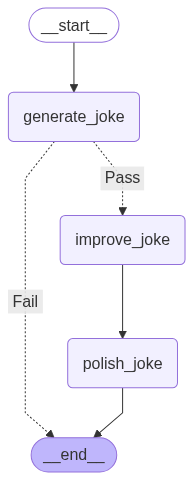

In [30]:
# view the generated graph
# display the graph
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
# invoke the graph
response = graph.invoke({"topic": "dogs"})
# console.print(f"[green] Final version -> [/green] {response.content}")

generate_joke() ->  Why did the dog sit in the shade?

Because he didn't want to be a hot dog!

improve_joke() ->  Why did the dog sit in the shade?
Because he didn't want to be a hot dog, and certainly not get grilled!

polish_joke() ->  Why did the dog sit in the shade?
Because he didn't want to be a hot dog, and certainly not get grilled! He was actually a vampire.